# SIR model on a network with characterization of Behavior and Age Classes
In this notebook we aim to build a network starting from real data that represents a population of **N** individuals and is structured similarly to Italian population. We start from real available data on age and contacts and use them to build the network properly. Then we define a custom SEIR model with Gillespie algorithm that handles both the SEIR dynamics on the network and the transmission of fear.

Our choice for behavioral characterization is the introduction of a percepted fear, that is a scalar assigned to each node, that if goes above a threshold changes the way such node interacts on the network, reducing its capability of making successful contacts. Hence our model is a mixture of a Epidemic model on a network and a complex contagion model for fear.

First off we import the desired **libraries**

In [1]:
import numpy as np
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, CenteredNorm
import networkx as nx
import EoN
import igraph as ig
from PIL import Image
from tqdm import tqdm

# make a dir to save everything
os.makedirs(f'SIR', exist_ok = True)
gif_flag = False

## Functions
We define here some useful function of our code:
- **draw_function(G)**: this function draws the network G according to the features of the nodes. Each color reèresents a state towards the disease, while the shape of the node represents the age class. **S** and **Sf** classes depend on fear level, if an individual is S and has a fear above the threshold it becomes a Sf individual
- **node_age_counter(G)**: this function counts how many nodes are in each age class
- **save_plot(G,time,filepath,pos)**: this function draws the graph G that is produced at a given time and with specified position pos. We shall use always the same pos once our first graph is created to both reduce computation time and make consistent plots

In [2]:
# draw func

def draw_function(G, path_save_plot):
    # Color by disease state
    disease_color_map = {'S': 'blue','Sf':'lightblue', 'I': 'red', 'R': 'green'}
    node_colors = [disease_color_map[G.nodes[node]['disease_state']] for node in G.nodes()]
    
    # Shape by age class
    age_shape_map = {'A': 'o', 'E': 's', 'Y': '^'}  # o=circle, s=square, ^=triangle
    
    pos = nx.arf_layout(G)
    
    # Draw nodes by age class (different shapes)
    for age_class, shape in age_shape_map.items():
        # Get nodes with this age class
        nodes_in_class = [node for node in G.nodes() if G.nodes[node]['age_class'] == age_class]
        # Get their colors based on disease state
        colors_in_class = [disease_color_map[G.nodes[node]['disease_state']] for node in nodes_in_class]
        # Get their positions
        pos_in_class = {node: pos[node] for node in nodes_in_class}
        
        # Draw this subset
        nx.draw_networkx_nodes(G, pos=pos_in_class, nodelist=nodes_in_class,
                               node_color=colors_in_class, node_size=int(10000/len(G.nodes)), 
                               node_shape=shape)
    
    # Draw edges once
    nx.draw_networkx_edges(G, pos=pos, width=0.1, alpha=0.5)
    
    # Optional: add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='S'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label='Sf'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='I'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='R'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Adult'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Elderly'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=8, label='Young'),
    ]
    plt.legend(handles=legend_elements, loc='best')
    
    plt.axis('off')
    if (path_save_plot):
        plt.savefig(path_save_plot)
    plt.show()

# function that counts how many nodes for each class
def node_age_counter(G):
    nodes_counter = {
        'A':0,
        'E':0,
        'Y':0
    }
    for i in range (len(G.nodes)):
        node = G.nodes[i]
        nodes_counter[node['age_class']]+=1
    return nodes_counter

# funct to save plot to
def save_plot(G,time,filepath,pos):
    # Color by disease state
    disease_color_map = {'S': 'blue','Sf':'lightblue', 'I': 'red', 'R': 'green'}
    node_colors = [disease_color_map[G.nodes[node]['disease_state']] for node in G.nodes()]
    
    # Shape by age class
    age_shape_map = {'A': 'o', 'E': 's', 'Y': '^'}  # o=circle, s=square, ^=triangle
     
    # Draw nodes by age class (different shapes)
    for age_class, shape in age_shape_map.items():
        # Get nodes with this age class
        nodes_in_class = [node for node in G.nodes() if G.nodes[node]['age_class'] == age_class]
        # Get their colors based on disease state
        colors_in_class = [disease_color_map[G.nodes[node]['disease_state']] for node in nodes_in_class]
        # Get their positions
        pos_in_class = {node: pos[node] for node in nodes_in_class}
        
        # Draw this subset
        nx.draw_networkx_nodes(G, pos=pos_in_class, nodelist=nodes_in_class,
                               node_color=colors_in_class, node_size=30, 
                               node_shape=shape)
    
    # Draw edges once
    nx.draw_networkx_edges(G, pos=pos, width=0.1, alpha=0.3)
    
    # Optional: add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='S'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label='Sf'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='I'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='R'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='Adult'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=8, label='Elderly'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='gray', markersize=8, label='Young'),
    ]
    #plt.legend(handles=legend_elements, loc='best')
    plt.title(f'Time-Step = {time}')
    plt.axis('off')
    plt.savefig(filepath)
    plt.close()

## Network building
Now we build our network. We start from a fully connected batch and then remove edges randomly from such batch until a specific fraction of edges is present. This is done to achieve a more realistic network rather than a fully connected initial batch, that is surely unrealistic.

### RESTART FROM THIS CELL TO RERUN EPIDEMICS

In [3]:
# function to create the graph according to the data we have
def graph_setupper(final_N,
              I0,
              fear_threshold):
    # start from a fully connected initial network (built according to the data of ages and contacts)
    # A, E, Y
    pops_prop = [0.5941353286169919,0.24706405947019197,0.15880061191281614]
    norm_contacts_matrix = pd.read_csv("norm_contacts_matrix.csv", index_col = 0).values.astype(float)
    
    # initial fully connected build
    # initial fear data distribution
    fear_mu = [0.1,0.2,0.2]
    fear_sigma = [0.03,0.07,0.03]

    # start from a clique of 3 nodes, 1 per class
    G = nx.Graph()
    
    age_class = 'A'
    fear = np.random.normal(fear_mu[0],fear_sigma[0])
    G.add_node(0, age_class = age_class, disease_state = 'S', fear = fear)
    age_class = 'E'
    fear = np.random.normal(fear_mu[1],fear_sigma[1])
    G.add_node(1, age_class = age_class, disease_state = 'S', fear = fear)
    age_class = 'Y'       
    fear = np.random.normal(fear_mu[2],fear_sigma[2])
    G.add_node(2, age_class = age_class, disease_state = 'S', fear = fear)
        
    # the initial setup is a FULLY CONNECTED
    edges = []
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            if i!=j:
                edges.append((i,j))
    G.add_edges_from(edges)
    
    # Remove randomly some edges to make it realistic
    total_edges = G.number_of_edges()
    target_edges = int(total_edges * 0.1)  # Keep 10% of edges
    edges_to_remove = total_edges - target_edges
    
    # Get list of all edges and randomly sample which ones to remove
    all_edges = list(G.edges())
    edges_removed = np.random.choice(len(all_edges), size=edges_to_remove, replace=False)
    
    for idx in edges_removed:
        u, v = all_edges[idx]
        G.remove_edge(u, v)

    # prob dict 
    # average links to sample from by class
    avg_links = {
        'A': 12,
        'E': 6,
        'Y': 20
    }
    # std for such average (sampling)
    std_links = {
        'A': 3,
        'E': 1,
        'Y': 3
    }
    
    ages=np.array(['A','E','Y'])

    starting_N = 3  # FIX: Define starting_N since we start with 3 nodes
    
    for i in range(starting_N, final_N):
        # Randomly assign age class to new node based on population distribution
        r = np.random.uniform(0,1)
        if r < pops_prop[0]:
            age_class = 'A'
            fear = np.random.normal(fear_mu[0],fear_sigma[0])
        elif r < (pops_prop[0]+pops_prop[1]):
            age_class = 'E'
            fear = np.random.normal(fear_mu[1],fear_sigma[1])
        else:
            age_class = 'Y'
            fear = np.random.normal(fear_mu[2],fear_sigma[2])
        
        # consistency check
        fear = min(fear,1)
        fear = max(fear,0)
        
        # Add the new node with its age class
        G.add_node(i, age_class=age_class, disease_state = 'S', fear = fear)
        
        # Sample number of links from normal distribution based on age class
        n_links = max(1, int(np.random.normal(avg_links[age_class], std_links[age_class])))
    
        link=0
        connected_nodes=[]
        if age_class=='A':
            idx=0
        elif age_class=='E':
            idx=1
        else:
            idx=2
        
        # FIX: Track failed attempts to avoid infinite loop
        max_attempts = 100  # Maximum attempts to find a valid connection
        attempts = 0
            
        while link < n_links and attempts < max_attempts:
            attempts += 1
            
            # select an age group based on contact probabilities
            target_age_probs = norm_contacts_matrix[idx]
            target_age = np.random.choice(ages, p=target_age_probs)
            
            # Get all nodes of the target age (excluding the current node)
            target_nodes = [node for node in G.nodes if G.nodes[node]['age_class'] == target_age and node != i]
            
            # FIX: Check if there are no available nodes
            if len(target_nodes) == 0:
                continue  # Try another age group
            
            # FIX: Check if all available nodes are already connected
            available_nodes = [node for node in target_nodes if node not in connected_nodes]
            if len(available_nodes) == 0:
                continue  # No more nodes available in this age group
            
            # degree of each potential target node for linking probability
            K = [G.degree(node) for node in available_nodes]
            K = np.array(K, dtype=float)
            total_degree = sum(K)
    
            # FIX: Handle case where all nodes have degree 0
            if total_degree == 0:
                link_prob = np.ones(len(K)) / len(K)
            else:
                link_prob = K/total_degree
    
            # Choose a node and add edge
            linked_node = np.random.choice(available_nodes, p=link_prob)
            connected_nodes.append(linked_node)
            G.add_edge(i, linked_node)
            link += 1
            attempts = 0  # Reset attempts after successful connection
    
    # initial feared check
    for i in range(len(G.nodes)):
        if(G.nodes[i]['fear']>fear_threshold):
            G.nodes[i]['disease_state'] = 'Sf'

    # some population will be infected at start
    N = len(G.nodes)
        
    # initial nodes infected are assigned here
    I_indices = np.random.choice(range(N), size=I0, replace=False)
    for idx in I_indices:
        G.nodes[idx]['disease_state'] = 'I'
    if (len(G.nodes)>= 1000):
        pos = None
    else:
        pos = nx.spring_layout(G)  # Changed from arf_layout
    return G, pos

## Network creation

In [30]:
final_N = 1000
I0 = 10
fear_threshold = 0.5
G, pos = graph_setupper(final_N,I0,fear_threshold)
if (len(G.nodes)<1000):
    draw_function(G,None)

# SIR implementation
Now we implement the SIR dynamics. In the first cell we set up the constants (that may vary based on nodes age class) and the initial condition of the network. Initial infected nodes are selected randomly.

## Parameter Setup and save files

In [31]:
#########################################
############## PARAMETERS ###############
#########################################
delta = 100          # exponent multiply factor in S -> Sf spontaneous transition

beta = {'A':0.004,
        'E':0.002,
        'Y':0.006} # transmission rate

r_beta = {'A':0.,
        'E':0.,
        'Y':0.} # beta rescaling factor based on age class

beta_f = {'A':0.18,
          'E':0.12,
          'Y':0.15}  # trasmission of fear (like infection) S + I -> Sf + I

mu_f = {'A':0.02,
        'E':0.013,
        'Y':0.012} ### transition Sf+S->2S or Sf + R -> S+R

mu_fear_dist = {'A':0.12,  # mean of the gaussian to sample from in S-> Sf spontaneous trans
                'E':0.08,
                'Y':0.1}  # S-> Sf spontaneous trans 

sigma_fear_dist = 0.05    # std of the gaussian to sample from in S-> Sf spontaneous trans

alpha= {'A':80.,
        'E':75.,
        'Y':100.}  # Sf + S -> 2 Sf 

gammaIR = {'A':0.01,
           'E':0.008,
           'Y':0.03}
###############################
###############################
###############################

param_string = f'{len(G.nodes)}_{I0}_{fear_threshold}_{delta}_{beta["A"]}_{beta["E"]}_{beta["Y"]}_{r_beta["A"]}_{r_beta["E"]}_' + \
               f'{r_beta["Y"]}_{beta_f["A"]}_{beta_f["E"]}_{beta_f["Y"]}_{gammaIR["A"]}_{gammaIR["E"]}_{gammaIR["Y"]}_' + \
               f'{mu_f["A"]}_{mu_f["E"]}_{mu_f["Y"]}_' + \
               f'{mu_fear_dist["A"]}_{mu_fear_dist["E"]}_{mu_fear_dist["Y"]}_{sigma_fear_dist}_' + \
               f'{alpha["A"]}_{alpha["E"]}_{alpha["Y"]}'

print("Number of initial Infected: ", sum(G.nodes[n]['disease_state'] == 'I' for n in G.nodes))
        
# make a dir for saving everything related to this
folder_path = f'SIR/{param_string}'
os.makedirs(folder_path,exist_ok = True)

# write out all parameters
'''with open(run_path+f"/run_{run_idx}_parameters.txt","w") as text_file:
    print(f"Parameters by class A, E, Y",file = text_file)
    print(f"beta: {beta['A']} {beta['E']} {beta['Y']}",file = text_file)
    print(f"r_beta: {r_beta['A']} {r_beta['E']} {r_beta['Y']}",file = text_file)
    print(f"gammaIR: {gammaIR['A']} {gammaIR['E']} {gammaIR['Y']}",file = text_file)
    print(f"gammaIR_resc: {gammaIR_resc['A']} {gammaIR_resc['E']} {gammaIR_resc['Y']}",file = text_file)
    print(f"mu_f: {mu_f['A']} {mu_f['E']} {mu_f['Y']}",file = text_file)
    print(f"mu_fear_dist: {mu_fear_dist['A']} {mu_fear_dist['E']} {mu_fear_dist['Y']}",file = text_file)
    print(f"sigma_fear_dist: {sigma_fear_dist}",file = text_file)
    print(f"alpha: {alpha['A']} {alpha['E']} {alpha['Y']}",file = text_file)
'''
# draw the network if it's all ok
path_save_plot = folder_path+f'/initial_cond.png'
if (len(G.nodes)<1000):    
    draw_function(G,path_save_plot)


Number of initial Infected:  10


## Degree distribution

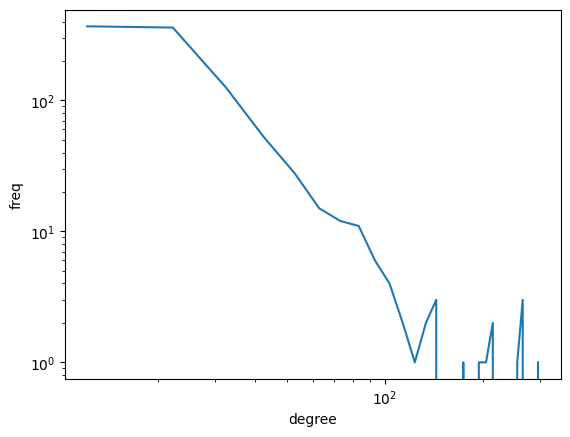

In [32]:
degrees = [d for n, d in G.degree()]

nbins = 30
bins = np.linspace(np.min(degrees),np.max(degrees),nbins)
counts, bins, _ = plt.hist(degrees, bins = bins)
plt.close()
plt.plot(bins[1:],counts)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('degree')
plt.ylabel('freq')
plt.show()

# CUSTOM SIR

In [33]:
def custom_SIR_with_fear(G, beta, gammaIR, r_beta,beta_f, mu_f, alpha,
                              delta, mu_fear_dist, sigma_fear_dist,
                              fear_threshold, tmax,modulo):

    nodes = list(G.nodes())
    neighbors = {n: list(G.neighbors(n)) for n in nodes}
    age = nx.get_node_attributes(G, 'age_class')

    status = {n: G.nodes[n]['disease_state'] for n in nodes}
    statuses = []
    fears = []
    fear   = {n: G.nodes[n]['fear'] for n in nodes}

    Ipop = sum(s == 'I' for s in status.values())
    Rpop = sum(s == 'R' for s in status.values())
    Ntot = len(nodes)

    t = 0.0
    times = []
    event_types = []
    event_counter = 0

    #pbar = tqdm(total=10000*modulo, desc="Gillespie events", unit="event")

    while Ipop > 0 and len(times)<tmax*modulo:

        events = []
        rates = []

        # --- spontaneous events ---
        for n in nodes:
            a = age[n]

            if status[n] == 'I':
                events.append(('IR', n))
                rates.append(gammaIR[a])

            elif status[n] == 'S':
                r = beta[a] * (1 - np.exp(-delta * Ipop / Ntot)) #* r_beta[a]
                if r > 0:
                    events.append(('fear', n))
                    rates.append(r)

            elif status[n] == 'Sf': #and Ipop / Ntot < Ntot/100:
                r = beta[a] * (1 - np.exp(-delta * 5 * Rpop / Ntot))  # * r_beta[a]
                if r > 0:
                    events.append(('fear_boredom', n))
                    rates.append(r)

        # --- compressed transmission events ---
        for i in nodes:
            if status[i] == 'I':
                a = age[i]
                neigh = neighbors[i]
    
                S_neigh  = [j for j in neigh if status[j] == 'S']
                Sf_neigh = [j for j in neigh if status[j] == 'Sf']
    
                if S_neigh:
                    # S + I → I + I
                    events.append(('SI', (i, S_neigh)))
                    rates.append(len(S_neigh) * beta[a])
    
                    # S + I → Sf + I
                    events.append(('SI_fear', (i, S_neigh)))
                    rates.append(len(S_neigh) * beta_f[a])
                    
                    # Sf + I -> 2I
                if Sf_neigh:
                    events.append(('SfI', (i, Sf_neigh)))
                    rates.append(len(Sf_neigh) * beta[a] * r_beta[a])
                    
            elif status[i] == 'R':
                a = age[i]
                neigh = neighbors[i]
    
                Sf_neigh  = [j for j in neigh if status[j] == 'Sf']
            
                if Sf_neigh:
                    # Sf + R -> S + R
                    events.append(('SfR', (i, Sf_neigh)))
                    rates.append(len(Sf_neigh) * mu_f[a])

            elif status[i] == 'S':
                a = age[i]
                neigh = neighbors[i]
    
                Sf_neigh  = [j for j in neigh if status[j] == 'Sf']
            
                if Sf_neigh:
                    # Sf + S -> 2S
                    events.append(('SfS_fear_gain', (i, Sf_neigh)))
                    rates.append(len(Sf_neigh) * beta[a] * alpha[a])

                    events.append(('SfS_fear_loss', (i,Sf_neigh)))
                    rates.append(len(Sf_neigh) * mu_f[a])

        total_rate = sum(rates)
        if total_rate == 0:
            break

        # --- Gillespie ---
        dt = np.random.exponential(1 / total_rate)
        t += dt

        idx = np.random.choice(len(events), p=np.array(rates) / total_rate)
        etype, data = events[idx]
        event_types.append(etype)

        # --- execute event ---
        if etype == 'IR':
            n = data
            status[n] = 'R'
            Ipop -= 1
            Rpop += 1

        elif etype == 'fear':
            n = data
            fear[n] = min(1, fear[n] + np.random.normal(mu_fear_dist[age[n]], sigma_fear_dist))
            if fear[n] > fear_threshold:
                status[n] = 'Sf'

        elif etype == 'fear_boredom':
            n = data
            fear[n] = max(0, fear[n] - np.random.normal(2*mu_fear_dist[age[n]], sigma_fear_dist))
            if fear[n] < fear_threshold:
                status[n] = 'S'

        elif etype == 'SI':
            i, Slist = data
            j = np.random.choice(Slist)
            status[j] = 'I'
            Ipop += 1

        elif etype == 'SI_fear':
            i, Slist = data
            j = np.random.choice(Slist)
            fear[j] = min(1, fear[j] + np.random.normal(mu_fear_dist[age[j]], sigma_fear_dist))
            if fear[j] > fear_threshold:
                status[j] = 'Sf'

        elif etype == 'SfI':
            i, Sflist = data
            j = np.random.choice(Sflist)
            status[j] = 'I'
            Ipop += 1
            
        elif etype == 'SfR':
            i, Slist = data
            j = np.random.choice(Slist)
            fear[j] = max(0, fear[j] - np.random.normal(mu_fear_dist[age[j]], sigma_fear_dist))
            if fear[j] < fear_threshold:
                status[j] = 'S'

        elif etype == 'SfS_fear_gain':
            i, Slist = data
            j = np.random.choice(Slist)
            fear[j] = min(1, fear[j] + np.random.normal(mu_fear_dist[age[j]],sigma_fear_dist))    # S with Sf can both have increment and decrement of fear
            if fear[j] > fear_threshold:
               status[j] = 'Sf'

        elif etype == 'SfS_fear_loss':
            i, Slist = data
            j = np.random.choice(Slist)
            fear[j] = max(0, fear[j] - np.random.normal(mu_fear_dist[age[j]],sigma_fear_dist))    # S with Sf can both have increment and decrement of fear
            if fear[j] < fear_threshold:
               status[j] = 'S'

        event_counter += 1
        #pbar.update(1)
        
        if event_counter % modulo== 0:
            times.append(t)
            statuses.append(status.copy())
            fears.append(fear.copy())
            event_types.append(etype)
            print(f'Current I pop: {Ipop}, Current R pop: {Rpop}, Saved events: {len(statuses)}, Seen events: {event_counter}, curr avg fear: {round(np.mean(np.array([f for f in fear.values()])),2)}')
        #if len(times) % modulo == 0:
        #    pbar.set_postfix(time=f"{t:.2f}", I=Ipop)
            
         
    return times, statuses, fears, event_types


In [ ]:
tmax = 50
modulo = 200
t, data,fears,event_types = custom_SIR_with_fear(G, beta, gammaIR, r_beta,beta_f, mu_f, alpha,delta, mu_fear_dist, sigma_fear_dist,fear_threshold,tmax,modulo)


Current I pop: 11, Current R pop: 1, Saved events: 1, Seen events: 200, curr avg fear: 0.15
Current I pop: 10, Current R pop: 2, Saved events: 2, Seen events: 400, curr avg fear: 0.16
Current I pop: 10, Current R pop: 2, Saved events: 3, Seen events: 600, curr avg fear: 0.16
Current I pop: 10, Current R pop: 2, Saved events: 4, Seen events: 800, curr avg fear: 0.16
Current I pop: 11, Current R pop: 2, Saved events: 5, Seen events: 1000, curr avg fear: 0.16
Current I pop: 12, Current R pop: 2, Saved events: 6, Seen events: 1200, curr avg fear: 0.17
Current I pop: 13, Current R pop: 2, Saved events: 7, Seen events: 1400, curr avg fear: 0.17
Current I pop: 13, Current R pop: 2, Saved events: 8, Seen events: 1600, curr avg fear: 0.17
Current I pop: 13, Current R pop: 2, Saved events: 9, Seen events: 1800, curr avg fear: 0.17


In [ ]:
ev = np.unique(np.array([event for event in event_types]), return_counts=True)
ev


In [ ]:
I = []
R = []
S = []
Sf = []
for time in range(len(t)):
    I.append(len(np.where(np.array(list(data[time].values()))=='I')[0])) 
    R.append(len(np.where(np.array(list(data[time].values()))=='R')[0]))
    S.append(len(np.where(np.array(list(data[time].values()))=='S')[0]))
    Sf.append(len(np.where(np.array(list(data[time].values()))=='Sf')[0]))

In [ ]:
plt.plot(t,S,label='S')
plt.plot(t,Sf,label='Sf', color ='lightblue')
plt.plot(t,np.array(S)+np.array(Sf),label='S+Sf', color ='navy')
plt.plot(t,I,label='I', color = 'red')
plt.plot(t,R,label='R', color= 'green')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Populations')
plt.grid(alpha = 0.6)
path = folder_path+f'/SIR.png'
plt.savefig(path)
plt.show()


In [ ]:
# only I plot (smooth)
max_time = len(t)
time_bins = np.arange(0,max(t),int(max(t))/100)
I = np.array(I)

# Calculate bin averages
binned_I = []
binned_time = []

for i in range(len(time_bins) - 1):
    # Find indices where t falls within current bin
    mask = (t >= time_bins[i]) & (t < time_bins[i+1])
    
    # If there are data points in this bin, calculate average
    if np.sum(mask) > 0:
        binned_I.append(np.mean(I[mask]))
        binned_time.append((time_bins[i] + time_bins[i+1]) / 2)  # Use bin center

# Convert to arrays
binned_time = np.array(binned_time)
binned_I = np.array(binned_I)

# Plot
plt.plot(binned_time, binned_I, color='red', label='I', linewidth=2)
plt.xlabel('time')
plt.ylabel('I')
plt.legend()
plt.grid(alpha=0.6)
path = folder_path + f'/Ipop_vs_time.png'
plt.savefig(path)
plt.show()


In [ ]:
avg_fear = np.zeros(len(fears))
std_fear = np.zeros(len(fears))
for i in range(len(fears)):
    fear_values = np.array([fear for fear in fears[i].values()])
    #print(fear_values)
    avg_fear[i]=np.mean(fear_values)
    std_fear[i]=np.std(fear_values)
times = np.arange(0,len(fears),1)
plt.plot(times,avg_fear, label = 'avg fear in pop')
plt.plot(times,avg_fear + std_fear, label = '1 std',color='lightblue')
plt.plot(times,avg_fear - std_fear,color='lightblue')
plt.xlabel('timestep')
plt.ylabel('fear')
plt.ylim(0,1)
plt.hlines(fear_threshold,xmin = times[0],xmax=times[-1],ls='--',color = 'red',label='fear threshold')
plt.grid(alpha = 0.6)
plt.legend()
path = folder_path+f'/fear_vs_time.png'
plt.savefig(path)
plt.show()

In [ ]:
age_classes = dict(G.nodes(data = 'age_class'))
avg_fear = np.zeros((len(fears),3))
age = [age for age in age_classes.values()]
for i in range(len(fears)):
    fear_values = np.array([fear for fear in fears[i].values()])
    counter = np.zeros(3)
    for value_idx in range(len(fear_values)):
        if(age[value_idx] == 'A'):
            avg_fear[i,0] += fear_values[value_idx]
            counter[0]+=1
        if(age[value_idx] == 'E'):
            avg_fear[i,1] += fear_values[value_idx]
            counter[1]+=1
        if(age[value_idx] == 'Y'):
            avg_fear[i,2] += fear_values[value_idx]
            counter[2]+=1

    # here compute the average at timestep i for all 3 classes
    avg_fear[i,:] = avg_fear[i,:] / counter


plt.plot(times,avg_fear[:,0],label='mean fear class A')
plt.plot(times,avg_fear[:,1],label='mean fear class E')
plt.plot(times,avg_fear[:,2],label='mean fear class Y')
plt.legend()
plt.grid(alpha = 0.6)
plt.xlabel('timestep')
plt.ylabel('fear')
path = folder_path+f'/fear_vs_time_byclass.png'
plt.show()

In [ ]:
avg_fear = np.zeros(len(fears))
std_fear = np.zeros(len(fears))
for i in range(len(fears)):
    fear_values = np.array([fear for fear in fears[i].values()])
    #print(fear_values)
    avg_fear[i]=np.mean(fear_values)
    std_fear[i]=np.std(fear_values)

In [ ]:
color = np.arange(0,len(I),1)
plt.scatter(I,avg_fear,c = color,cmap = 'viridis', s = 5)
plt.xlabel('I population')
plt.ylabel('average fear')
plt.colorbar(label='time')
plt.grid(alpha = 0.6)
path = folder_path+f'/fear_vs_I_samu.png'
plt.savefig(path)
plt.show()

In [ ]:
# times of snapshot
if gif_flag:
    snapshot_skip = 100
    for i,time in enumerate(t):
        if i%snapshot_skip==0:
            L = nx.Graph()
            L.add_nodes_from(data[i])
            L.add_edges_from(G.edges)
            nx.set_node_attributes(L, values=data[i], name='disease_state')
            nx.set_node_attributes(L, values=fears[i], name='fear')
            nx.set_node_attributes(L, values=age_classes, name='age_class')
        
            # select pos once for all plots
            if i == 0:
                pos = nx.arf_layout(G)
            
            # make a folder
            os.makedirs(folder_path+f"/frames", exist_ok=True)
            filepath = folder_path+f'/frames/network_status_time_{i}.png'
            save_plot(L,i,filepath,pos)

In [ ]:
if gif_flag:
    # produce GIF
    # make a folder
    os.makedirs(folder_path+f"/gifs", exist_ok=True)
    frames = []
    for i,time in enumerate(t):
        if i%snapshot_skip==0:
            img = Image.open(folder_path+f'/frames/network_status_time_{i}.png')
            frames.append(img)
            
            frames[0].save(folder_path+f"/gifs/network_gif.gif", 
                           save_all=True, 
                           append_images=frames[1:], 
                           duration=900,  # milliseconds per frame
                           loop=0)
        
    print("GIF saved as network_animation.gif")

# Study of the epidemic


In [ ]:
# t data fears age_classes
dt = 0.8 # time unit
time_bins = np.arange(0,max(t)+dt,dt)

# arrays
new_infections = np.zeros(len(time_bins)-1)
new_feared = np.zeros(len(time_bins)-1)

# for each interval
for i in range(len(time_bins) - 1):
    t_start = time_bins[i]       # time value start
    t_end = time_bins[i + 1]     # time value end
        
    # find events in this interval
    events_in_interval = [(t, s, f) for t, s, f in zip(t, data, fears) 
                          if t_start <= t < t_end]
        
    if len(events_in_interval) >= 2:
        
        for j in range(1, len(events_in_interval)):
            prev_status = events_in_interval[j-1][1]
            curr_status = events_in_interval[j][1]
                
            for node in prev_status:
                if prev_status[node] in ['S', 'Sf'] and curr_status[node] == 'I':
                    new_infections[i] += 1
                if prev_status[node] == 'S' and curr_status[node] == 'Sf':
                    new_feared[i] += 1
                elif prev_status[node] == 'Sf' and curr_status[node] == 'S':
                    new_feared[i] -= 1

            
            
        
            

## Fear level vs being infected

In [ ]:
infection_fears = [] # to save data

for time in range(1,len(data)):
    # time index that runs across all timesteps
    previous_states = [state for state in data[time-1].values()]      ## prev states  
    curr_states = [state for state in data[time].values()]            ## curr states
    previous_fears = [fear for fear in fears[time-1].values()]
    
    for node_idx in range(len(previous_states)):
        # infection check
        if(previous_states[node_idx] in ['S','Sf'] and curr_states[node_idx] == 'I'):
            # save fear data
            infection_fears.append(previous_fears[node_idx])

bins = np.arange(0,1,0.05)
counts, _, _ = plt.hist(infection_fears,bins=bins,label ='p of getting I vs fear')
plt.vlines(fear_threshold,ymin = min(counts)-0.2,ymax=max(counts)+0.2,label='fear_threshold', ls = '--', color = 'red')
plt.legend()
plt.xlabel('fear')
plt.ylabel('# of infections')
p_left = np.sum(counts[np.where(bins<fear_threshold)[0]]) / np.sum(counts)
p_right = 1. - p_left

plt.title('Fear when infected histogram')
plt.text(0.,max(counts)*0.1,s=f'prob left threshold = {round(p_left,3)}', bbox=dict(boxstyle='square',facecolor='white',edgecolor='black'))
plt.text(0.55,max(counts)*0.1,s=f'prob right threshold = {round(p_right,3)}', bbox=dict(boxstyle='square',facecolor='white',edgecolor='black'))
plt.savefig(folder_path+"/fear_level_prob_of_getting_I.png")
plt.show()



## Fear vs new infections

In [ ]:
tot_feared = np.cumsum(new_feared)
colors = np.arange(len(tot_feared))
plt.scatter(tot_feared,new_infections, c = colors, cmap = 'viridis',label='new infections vs feared')
#plt.plot(time_bins[1:],tot_feared, label = 'total feared dt', ls = '--')
plt.legend()
plt.grid(alpha = 0.6)
plt.xlabel(f'total feared')
plt.ylabel(f'new infections')
#plt.xscale('log')
plt.colorbar(label='Time progression')
#plt.yscale('log')
plt.savefig(folder_path+f"/newI_vs_totalFear_plot.png")
plt.show()

In [ ]:
# percentage of infected per population
final_snapshot = zip(data[-1].values(),age_classes.values())
tot_A = len(np.where(np.array([clas for clas in age_classes.values()])=='A')[0])
tot_E = len(np.where(np.array([clas for clas in age_classes.values()])=='E')[0])
tot_Y = len(np.where(np.array([clas for clas in age_classes.values()])=='Y')[0])
final_ar_A = 0
final_ar_E = 0    # final attack rates
final_ar_Y = 0 

for i,j in final_snapshot:
    if (i == 'R' and j == 'A'):
        final_ar_A += 1
    if (i == 'R' and j == 'E'):
        final_ar_E += 1
    if (i == 'R' and j == 'Y'):
        final_ar_Y += 1
final_attack_rates_per_class = [final_ar_A/tot_A,final_ar_E/tot_E,final_ar_Y/tot_Y]
final_attack_rates_per_class

In [ ]:
# trend of infected per population
trends = np.zeros((len(data),3))
for t in range(len(data)):
    snapshot = zip(data[t].values(),age_classes.values())
    tot_A = len(np.where(np.array([clas for clas in age_classes.values()])=='A')[0])
    tot_E = len(np.where(np.array([clas for clas in age_classes.values()])=='E')[0])
    tot_Y = len(np.where(np.array([clas for clas in age_classes.values()])=='Y')[0])
    final_ar_A = 0
    final_ar_E = 0    # final attack rates
    final_ar_Y = 0 
    
    for i,j in snapshot:
        if (i in ['I','R'] and j == 'A'):
            final_ar_A += 1
        if (i in ['I','R'] and j == 'E'):
            final_ar_E += 1
        if (i in ['I','R'] and j == 'Y'):
            final_ar_Y += 1
    final_attack_rates_per_class = [final_ar_A/tot_A,final_ar_E/tot_E,final_ar_Y/tot_Y]
    trends[t,:] = final_attack_rates_per_class
    
# plot logic
plt.plot(times,trends[:,0]*100,label ='A')
plt.plot(times,trends[:,1]*100,label ='E')
plt.plot(times,trends[:,2]*100,label ='Y')
plt.xlabel('event')
plt.ylabel('% of pop infected')
plt.legend()
plt.grid(alpha = 0.6)
plt.savefig(folder_path + "/perc_pop_vs_time_class.png")

plt.show()

In [ ]:
# infections vs degree
deg_np = np.array([deg[1] for deg in G.degree])
unique_degrees = np.unique(deg_np)
final_states = np.array([state for state in data[-1].values()])

prob_R_given_k = []  
degrees_for_plot = []

for k in unique_degrees:
    nodes_with_degree_k = (deg_np == k)
    # how many are R
    num_R = np.sum(final_states[nodes_with_degree_k] == 'R')  
    total = np.sum(nodes_with_degree_k)
    # probability
    prob_R_given_k.append(num_R / total)
    degrees_for_plot.append(k)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(degrees_for_plot, prob_R_given_k)
plt.xlabel('Degree k')
plt.ylabel('P(R | k)')
plt.xscale('log')
plt.title('Probability of being Recovered vs Degree')
plt.grid(alpha=0.6)
plt.savefig(folder_path + "/prob_R_vs_degree.png")
plt.show()

In [ ]:
# epidemic size (fraction of N that is R at the end of time)
es = R[-1] / len(G.nodes)
# reproductive ratio of fear
alpha_np = np.array([val for val in alpha.values()])
beta_np = np.array([val for val in beta.values()])
muf_np = np.array([val for val in mu_f.values()])
gammaIR_np = np.array([val for val in gammaIR.values()])
Rf = alpha_np * beta_np / muf_np
# basic reproductive ratio (general def on networks)
deg_np = np.array([deg[1] for deg in G.degree])
deg2_np = np.array([deg[1]**2 for deg in G.degree])
R0 = (beta_np / gammaIR_np) * (np.mean(deg2_np) - np.mean(deg_np)) / np.mean(deg_np)
# timestep of peak infection
timestep_max_I = np.argmax(I)
# timestep of peak fear
timestep_max_f = np.argmax(avg_fear)

In [ ]:
events, counts = np.unique(event_types, return_counts=True)
for event, count in zip(events,counts):
    print(event,count)

In [ ]:
log_path = folder_path+f'/event_log.txt'
with open(log_path,"w") as text_file:
    print(f"Event type: ###",file = text_file)
    print(f"IR recovery: {counts[np.where(events == 'IR')[0]]}",file = text_file)
    print(f"Fear spontaneous S->Sf: {counts[np.where(events == 'fear')[0]]}",file = text_file)
    print(f"Fear removal Sf+R -> S+R or Sf+S-> 2S: {counts[np.where(events == 'SfR')[0]]}",file = text_file)
    print(f"Fear transmission Sf+S->2S: {counts[np.where(events == 'SfS')[0]]}",file = text_file)
    print(f"Fear removal boredom Sf -> S: {counts[np.where(events == 'fear_boredom')[0]]}",file = text_file)
    print(f"Disease transmission S+I->2I: {counts[np.where(events == 'SI')[0]]}",file = text_file)
    print(f"Disease transmission Sf+I->2I: {counts[np.where(events == 'SfI')[0]]}",file = text_file)
    print(f"OTHER",file = text_file)
    print(f"Epidemic size (total fraction): {es}",file = text_file)
    print(f"Rf by age class: {Rf}",file = text_file)
    print(f"R0 by age class: {R0}",file = text_file)
    print(f"timestep of max I: {timestep_max_I}",file = text_file)
    print(f"timestep of max fear: {timestep_max_f}",file = text_file)
    print(f"Final attack rates per class: {final_attack_rates_per_class}",file = text_file)
    
    